In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [12]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [14]:
def load_and_explore_data(filepath):
    """
    Load the dataset and perform initial exploration
    
    Parameters:
    -----------
    filepath : str
        Path to the CSV file
    
    Returns:
    --------
    pd.DataFrame: Loaded dataset
    """
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Display basic information
    print("Dataset Information:")
    print(df.info())
    
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    return df

In [15]:
def visualize_data(df):
    """
    Create visualizations for the dataset
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataset
    """
    # Set up the plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribution of Wholesale Prices by Region
    sns.boxplot(x='Region', y='Wholesale Price (₹/kg)', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('Wholesale Prices by Region')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Scatter Plot: Production Volume vs Domestic Consumption
    sns.scatterplot(x='Production Volume (Tonnes)', y='Domestic Consumption (Tonnes)', 
                    hue='Season', data=df, ax=axes[0, 1])
    axes[0, 1].set_title('Production Volume vs Domestic Consumption')
    
    # 3. Correlation Heatmap
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1, 0], center=0)
    axes[1, 0].set_title('Correlation Heatmap')
    
    # 4. Bar Plot: Average Wholesale Price by Seed Type
    df.groupby('Seed Type')['Wholesale Price (₹/kg)'].mean().plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Average Wholesale Price by Seed Type')
    axes[1, 1].set_xlabel('Seed Type')
    axes[1, 1].set_ylabel('Average Wholesale Price (₹/kg)')
    
    plt.tight_layout()
    plt.show()

In [20]:
def prepare_features(df):
    """
    Prepare features for machine learning
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataset
    
    Returns:
    --------
    tuple: X (features), y_price, y_consumption
    """
    # Separate features and targets
    categorical_features = ['Region', 'Season', 'Seed Type', 'Storage Availability']
    numerical_features = [
        'Production Volume (Tonnes)', 
        'Cultivated Area (Hectares)', 
        'Yield (kg/ha)', 
        'Irrigation Coverage (%)', 
        'Fertilizer Usage (kg/ha)', 
        'Pesticide Usage (L/ha)', 
        'Rainfall (mm)', 
        'Temperature (°C)', 
        'Humidity (%)', 
        'Labor Availability'
    ]
    
    # Preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    # Prepare features and targets
    X = df[numerical_features + categorical_features]
    y_price = df['Wholesale Price (₹/kg)']
    y_consumption = df['Domestic Consumption (Tonnes)']
    
    return X, y_price, y_consumption, preprocessor

In [17]:
def train_and_evaluate_models(X, y_price, y_consumption, preprocessor):
    """
    Train multiple regression models and evaluate performance
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y_price : pd.Series
        Wholesale price target
    y_consumption : pd.Series
        Domestic consumption target
    preprocessor : ColumnTransformer
        Preprocessing pipeline
    
    Returns:
    --------
    dict: Model performance metrics
    """
    # Split the data
    X_train, X_test, y_price_train, y_price_test, y_consumption_train, y_consumption_test = train_test_split(
        X, y_price, y_consumption, test_size=0.2, random_state=42
    )
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # Store results
    results = {
        'Price Prediction': {},
        'Consumption Prediction': {}
    }
    
    # Train and evaluate for each model
    for name, model in models.items():
        # Price Prediction Pipeline
        price_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Consumption Prediction Pipeline
        consumption_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Fit and predict for price
        price_pipeline.fit(X_train, y_price_train)
        y_price_pred = price_pipeline.predict(X_test)
        
        # Fit and predict for consumption
        consumption_pipeline.fit(X_train, y_consumption_train)
        y_consumption_pred = consumption_pipeline.predict(X_test)
        
        # Evaluate price prediction
        results['Price Prediction'][name] = {
            'MSE': mean_squared_error(y_price_test, y_price_pred),
            'MAE': mean_absolute_error(y_price_test, y_price_pred),
            'R2': r2_score(y_price_test, y_price_pred)
        }
        
        # Evaluate consumption prediction
        results['Consumption Prediction'][name] = {
            'MSE': mean_squared_error(y_consumption_test, y_consumption_pred),
            'MAE': mean_absolute_error(y_consumption_test, y_consumption_pred),
            'R2': r2_score(y_consumption_test, y_consumption_pred)
        }
    
    return results

In [18]:
def perform_pca(X, preprocessor):
    """
    Perform Principal Component Analysis
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    preprocessor : ColumnTransformer
        Preprocessing pipeline
    
    Returns:
    --------
    tuple: PCA object, explained variance
    """
    # Fit the preprocessor
    X_processed = preprocessor.fit_transform(X)
    
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_processed)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.show()
    
    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.show()
    
    return pca, pca.explained_variance_ratio_

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Region                         6000 non-null   object
 1   Season                         6000 non-null   object
 2   Production Volume (Tonnes)     6000 non-null   int64 
 3   Cultivated Area (Hectares)     6000 non-null   int64 
 4   Yield (kg/ha)                  6000 non-null   int64 
 5   Irrigation Coverage (%)        6000 non-null   int64 
 6   Seed Type                      6000 non-null   object
 7   Fertilizer Usage (kg/ha)       6000 non-null   int64 
 8   Pesticide Usage (L/ha)         6000 non-null   int64 
 9   Storage Availability           6000 non-null   object
 10  Rainfall (mm)                  6000 non-null   int64 
 11  Temperature (°C)               6000 non-null   int64 
 12  Humidity (%)                   6000 non-n

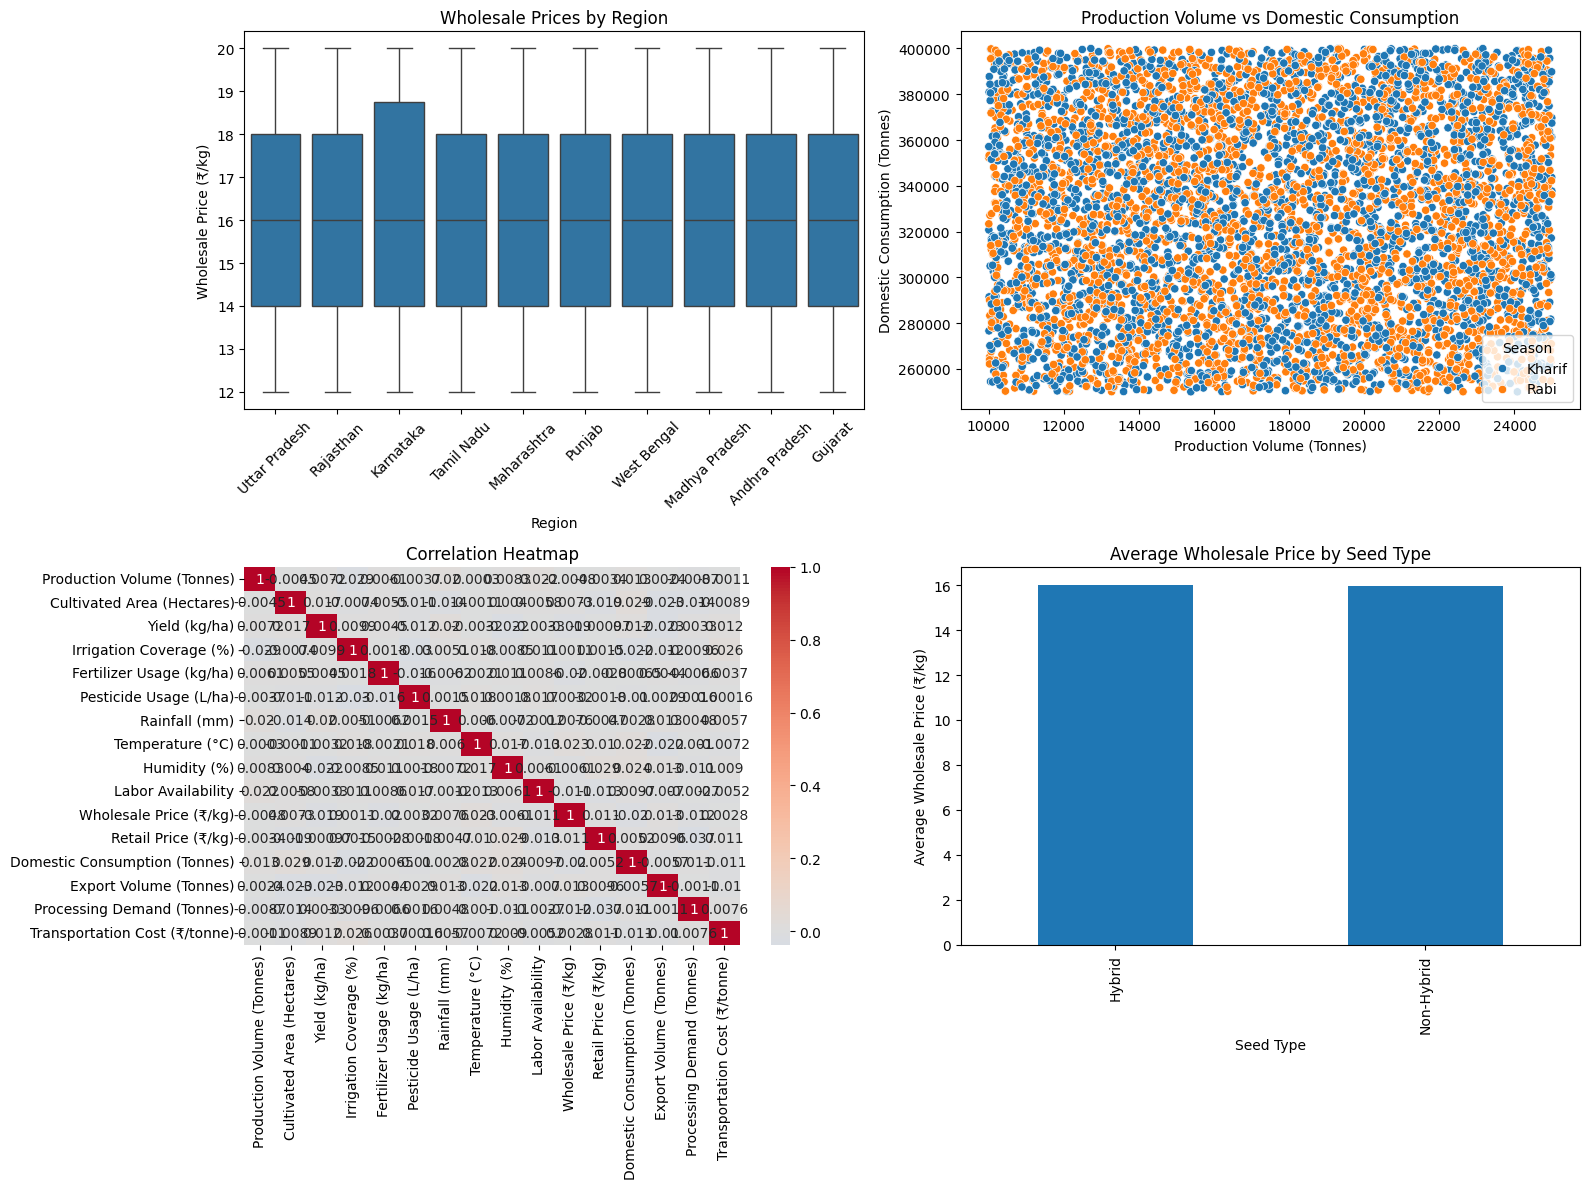

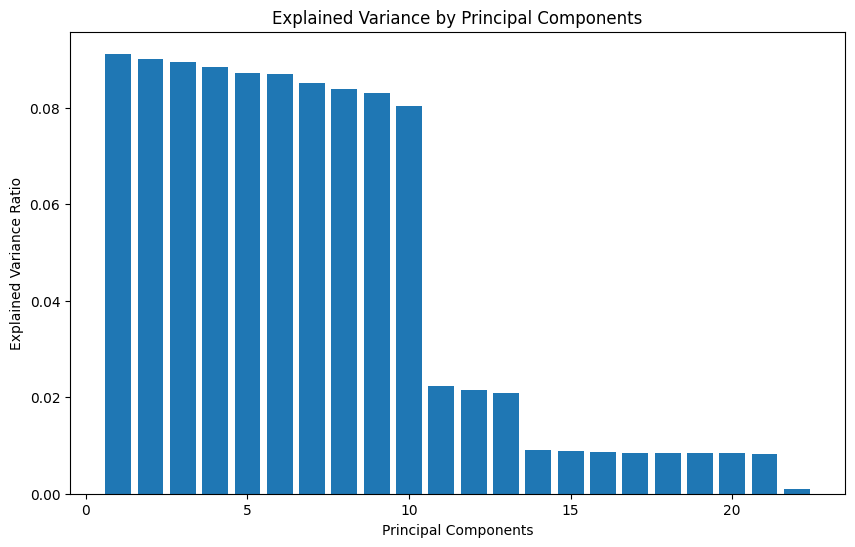

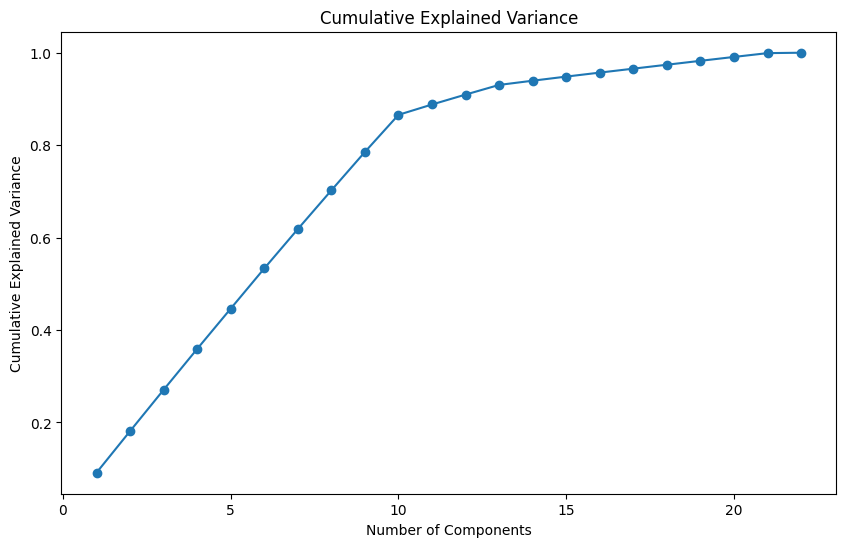


Price Prediction Model Performance:
Linear Regression:
  MSE: 6.6717
  MAE: 2.2328
  R2: -0.0024
Ridge Regression:
  MSE: 6.6716
  MAE: 2.2327
  R2: -0.0024
Lasso Regression:
  MSE: 6.6562
  MAE: 2.2219
  R2: -0.0001
Random Forest:
  MSE: 6.7540
  MAE: 2.2369
  R2: -0.0148
Gradient Boosting:
  MSE: 6.7253
  MAE: 2.2415
  R2: -0.0105

Consumption Prediction Model Performance:
Linear Regression:
  MSE: 1905392688.1408
  MAE: 37785.9652
  R2: -0.0107
Ridge Regression:
  MSE: 1905344925.7290
  MAE: 37785.5634
  R2: -0.0107
Lasso Regression:
  MSE: 1905271250.6179
  MAE: 37784.8121
  R2: -0.0107
Random Forest:
  MSE: 1924250447.1852
  MAE: 37929.1016
  R2: -0.0207
Gradient Boosting:
  MSE: 1912039687.2331
  MAE: 37702.4880
  R2: -0.0143


In [21]:
def main(filepath):
    # 1. Load and Explore Data
    df = load_and_explore_data(filepath)
    
    # 2. Visualize Data
    visualize_data(df)
    
    # 3. Prepare Features
    X, y_price, y_consumption, preprocessor = prepare_features(df)
    
    # 4. Perform PCA
    pca, explained_variance = perform_pca(X, preprocessor)
    
    # 5. Train and Evaluate Models
    model_results = train_and_evaluate_models(X, y_price, y_consumption, preprocessor)
    
    # Print Model Results
    print("\nPrice Prediction Model Performance:")
    for model, metrics in model_results['Price Prediction'].items():
        print(f"{model}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    print("\nConsumption Prediction Model Performance:")
    for model, metrics in model_results['Consumption Prediction'].items():
        print(f"{model}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
    
    return df, X, y_price, y_consumption, pca, model_results

# Run the analysis
filepath = 'Tomato-dataset.csv'
df, X, y_price, y_consumption, pca, model_results = main(filepath)